# Bounding Box Alignment
Stage 2/3 synthetic data generation notebook

In [221]:
import os
import json
import shutil
import timeit
import trimesh
import pyrender
import numpy as np
from PIL import Image
from random import sample
import matplotlib.pyplot as plt

In [276]:
def load_step_part(filepath):
    mesh = trimesh.load_mesh(filepath)
    mesh.apply_translation(-mesh.centroid)
    mesh.apply_scale(1000)
    return mesh

In [277]:
MODEL_DIR = "models/"
IMG_SIZE = 512

step_files = [f for f in os.listdir(MODEL_DIR) if f.lower().endswith(".step")]
r = pyrender.OffscreenRenderer(viewport_width=IMG_SIZE, viewport_height=IMG_SIZE)

In [324]:
steps = sample(step_files, 15)
print(steps)

meshes = [load_step_part(os.path.join(MODEL_DIR, step)) for step in steps]
print(meshes)

['IntakeWheel.STEP', 'CounterborePatternSpacer6.STEP', 'UChannel7H.STEP', 'Side2Post1PillowBlock4ID.STEP', 'Side1Post2ClampingMount32ID.STEP', 'SquareBeam5H.STEP', 'HubMountAcetalSprocket38T.STEP', 'LBeam29H.STEP', 'HubMountControlArm24.STEP', 'Shaft12ROD144.STEP', 'Shaft12ROD48.STEP', 'OpenGoRAIL192.STEP', 'ThreadedLBracket5H.STEP', 'FlatBeam5H.STEP', 'Pulley3P6DID18T.STEP']
[<trimesh.Trimesh(vertices.shape=(23444, 3), faces.shape=(21684, 3))>, <trimesh.Trimesh(vertices.shape=(23178, 3), faces.shape=(25616, 3))>, <trimesh.Trimesh(vertices.shape=(57954, 3), faces.shape=(57052, 3))>, <trimesh.Trimesh(vertices.shape=(26374, 3), faces.shape=(32586, 3))>, <trimesh.Trimesh(vertices.shape=(41528, 3), faces.shape=(61368, 3))>, <trimesh.Trimesh(vertices.shape=(12070, 3), faces.shape=(12882, 3))>, <trimesh.Trimesh(vertices.shape=(8676, 3), faces.shape=(7976, 3))>, <trimesh.Trimesh(vertices.shape=(10940, 3), faces.shape=(10924, 3))>, <trimesh.Trimesh(vertices.shape=(2532, 3), faces.shape=(2516, 

In [412]:
def random_grayscale_color(min_val=0.2, max_val=0.8, tint_strength=0.0):
    base = np.random.uniform(min_val, max_val)
    r = np.clip(base + np.random.uniform(-tint_strength, tint_strength), 0, 1)
    g = np.clip(base + np.random.uniform(-tint_strength, tint_strength), 0, 1)
    b = np.clip(base + np.random.uniform(-tint_strength, tint_strength), 0, 1)
    return np.array([r, g, b])

# Inverse of gluLookAt
def look_at(v_e, v_t=np.array((0, 0, 0)), up=np.array((0, 1, 0))):
    forward = v_t - v_e
    forward /= np.linalg.norm(forward)
    up = np.array([1, 0, 0]) if abs(np.dot(forward, up)) > 0.999 else up

    right = np.cross(forward, up)
    right /= np.linalg.norm(right)

    up = np.cross(right, forward)

    rot = np.eye(4)
    rot[:3, 0] = right
    rot[:3, 1] = up
    rot[:3, 2] = -forward

    trans = np.eye(4)
    trans[:3, 3] = v_e

    pose = trans @ rot
    return pose

In [413]:
look_at(np.array([0, 1, 0], dtype=np.dtypes.Float64DType))

array([[0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [251]:
def path_to_mesh(path):
    lines = []
    for entity in path.entities:
        segment = entity.discrete(path.vertices)
        for i in range(len(segment) - 1):
            lines.append(segment[i])
            lines.append(segment[i + 1])

    lines_np = np.array(lines, dtype=np.float32)

    line_mesh = pyrender.Primitive(
        positions=lines_np,
        mode=1,
        material=pyrender.MetallicRoughnessMaterial(baseColorFactor=(0, 0, 0)),
    )
    return pyrender.Mesh([line_mesh])

[[-15.97038668  -2.70068506 -15.97498847]
 [ 15.97039763   3.29931499  15.97501221]]


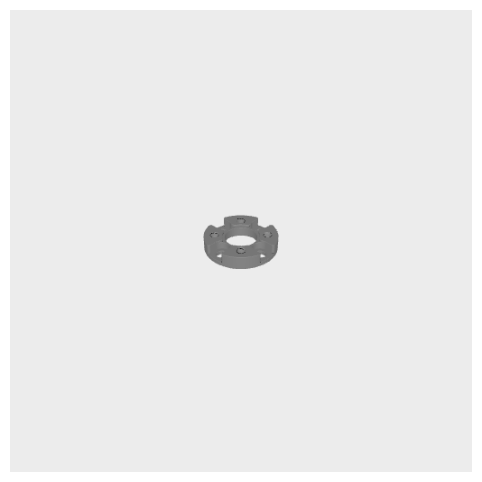

In [325]:
m = meshes[1].copy()
print(m.bounds)
m.merge_vertices()
edges = m.face_adjacency_angles >= np.radians(90)
right_angles = trimesh.load_path(m.vertices[m.face_adjacency_edges[edges]])

scene = pyrender.Scene(
    bg_color=np.append(random_grayscale_color(0.9, 0.975), 1.0),
    ambient_light=[0.3, 0.3, 0.3, 1.0],
)
cam_pose = look_at(np.array([100.0, 100.0, 100.0]))

scene = pyrender.Scene(
    bg_color=np.append(random_grayscale_color(0.9, 0.975), 1.0),
    ambient_light=[0.3, 0.3, 0.3, 1.0]
)

camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)

scene.add(camera, pose=cam_pose)

light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0)
scene.add(light, pose=cam_pose)
scene.add(pyrender.Mesh.from_trimesh(meshes[1],
    material=pyrender.MetallicRoughnessMaterial(
        baseColorFactor=np.append(random_grayscale_color(0.35, 0.45), 1.0),
        metallicFactor=0.8,
        roughnessFactor=0.8,
    )
))
scene.add(path_to_mesh(right_angles))
color, _ = r.render(scene)

plt.figure(figsize=(8, 6))
plt.axis("off")
plt.imshow(color)
plt.show()
# trimesh.Scene([m, right_angles]).show()

C:\Users\ryan\AppData\Local\Temp\ipykernel_24036\3057696261.py:227: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  assembled_scene, poses, origin_index = assemble(meshes)
C:\Users\ryan\AppData\Local\Temp\ipykernel_24036\3057696261.py:156: DeprecationWarning: `Scene.dump(concatenate=True)` DEPRECATED FOR REMOVAL APRIL 2025: replace with `Scene.to_geometry()`
  full_mesh = trimesh.Scene(meshes_transformed).dump(concatenate=True)


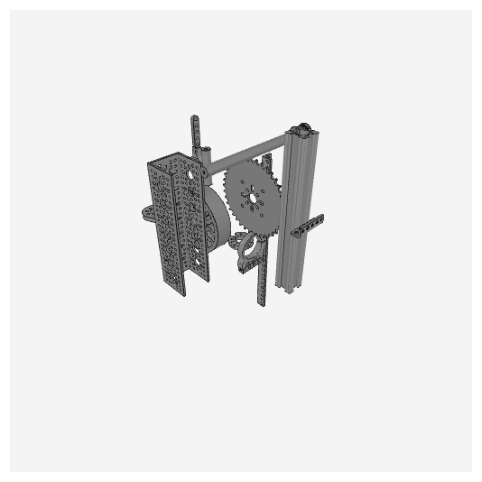

In [ ]:
import random
import trimesh
import pyrender
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R


def intersects(bounds1, bounds2):
    return np.all(bounds1[0] < bounds2[1]) and np.all(bounds1[1] > bounds2[0])


def rand_face_transform(target_mesh, source_mesh):
    target_box = target_mesh.bounding_box_oriented
    source_box = source_mesh.bounding_box_oriented

    target_face = random.randint(0, 5)
    source_face = random.randint(0, 5)

    target_min, target_max = target_box.bounds
    source_min, source_max = source_box.bounds

    def get_face_vector(idx, min_, max_):
        axis = idx % 3
        direction = -1 if idx < 3 else 1
        face_center = np.array(
            [
                (
                    min_[i]
                    if direction == -1 and i == axis
                    else (
                        max_[i]
                        if direction == 1 and i == axis
                        else (min_[i] + max_[i]) / 2
                    )
                )
                for i in range(3)
            ]
        )
        normal = np.eye(3)[axis] * direction
        return face_center, normal

    t_face_center, t_normal = get_face_vector(target_face, target_min, target_max)
    s_face_center, s_normal = get_face_vector(source_face, source_min, source_max)

    v1 = s_normal / np.linalg.norm(s_normal)
    v2 = -t_normal / np.linalg.norm(t_normal)

    axis = np.cross(v1, v2)
    angle = np.arccos(np.clip(np.dot(v1, v2), -1, 1))
    if np.linalg.norm(axis) < 1e-6:
        R_mat = np.eye(3)
    else:
        axis = axis / np.linalg.norm(axis)
        R_mat = trimesh.transformations.rotation_matrix(angle, axis)[:3, :3]

    s_transformed_face = R_mat @ s_face_center
    translation = t_face_center - s_transformed_face

    rotation_euler = R.from_matrix(R_mat).as_euler("xyz", degrees=True)

    return translation, rotation_euler


def center_assembly(meshes):
    all_bounds = np.vstack([m.bounds for m in meshes])
    overall_centroid = (np.min(all_bounds, axis=0) + np.max(all_bounds, axis=0)) / 2

    mesh_centers = np.array([m.bounding_box.centroid for m in meshes])
    distances = np.linalg.norm(mesh_centers - overall_centroid, axis=1)
    reference_idx = np.argmin(distances)
    reference_center = mesh_centers[reference_idx]

    offset = reference_center
    for m in meshes:
        m.apply_translation(-offset)

    return meshes, reference_idx


def assemble(mesh_list, max_attempts=100):
    placed = []
    poses = []

    mesh0 = mesh_list[0].copy()
    placed.append(mesh0)
    meshes_transformed = [mesh0]
    poses.append((np.zeros(3), np.zeros(3)))

    for mesh in mesh_list[1:]:
        added = False
        attempts = 0

        while not added and attempts < max_attempts:
            target = random.choice(placed)
            position, rotation_euler = rand_face_transform(target, mesh)

            T = np.eye(4)
            T[:3, :3] = R.from_euler("xyz", rotation_euler, degrees=True).as_matrix()
            T[:3, 3] = position

            mesh_transformed = mesh.copy()
            mesh_transformed.apply_transform(T)

            if not any(intersects(mesh_transformed.bounds, p.bounds) for p in placed):
                placed.append(mesh_transformed)
                meshes_transformed.append(mesh_transformed)
                poses.append((position, rotation_euler))
                added = True
            attempts += 1

    all_bounds = np.vstack([m.bounds for m in meshes_transformed])
    overall_centroid = (np.min(all_bounds, axis=0) + np.max(all_bounds, axis=0)) / 2

    mesh_centers = np.array([m.bounding_box.centroid for m in meshes_transformed])
    distances = np.linalg.norm(mesh_centers - overall_centroid, axis=1)
    reference_idx = np.argmin(distances)
    reference_center = mesh_centers[reference_idx]

    offset = reference_center

    for i, m in enumerate(meshes_transformed):
        m.apply_translation(-offset)

        pos, rot = poses[i]
        new_pos = pos - offset
        poses[i] = (new_pos, rot)

    return meshes_transformed, poses, reference_idx


def path_to_mesh(path):
    lines = []
    for entity in path.entities:
        segment = entity.discrete(path.vertices)
        for i in range(len(segment) - 1):
            lines.append(segment[i])
            lines.append(segment[i + 1])

    lines_np = np.array(lines, dtype=np.float32)

    line_mesh = pyrender.Primitive(
        positions=lines_np,
        mode=1,
        material=pyrender.MetallicRoughnessMaterial(
            baseColorFactor=(0, 0, 0),
            metallicFactor=0.8,
            roughnessFactor=0.8,
        ),
    )
    return pyrender.Mesh([line_mesh])


def render_scene(meshes_transformed: list[trimesh.Trimesh]):
    full_mesh = trimesh.Scene(meshes_transformed).dump(concatenate=True)
    bounds = full_mesh.bounds
    size = np.linalg.norm(bounds[1] - bounds[0])

    direction = np.array([1, 1, 1])
    direction = direction / np.linalg.norm(direction)

    camera_distance = size * 1.25  # adjust zoom level
    cam_position = direction * camera_distance
    cam_pose = look_at(cam_position)

    scene = pyrender.Scene(
        bg_color=np.append(random_grayscale_color(0.9, 0.975), 1.0),
        ambient_light=[0.3, 0.3, 0.3, 1.0],
    )
    for mesh in meshes_transformed:
        m = mesh.copy()
        m.merge_vertices()
        material = pyrender.MetallicRoughnessMaterial(
            baseColorFactor=np.append(random_grayscale_color(0.35, 0.45), 1.0),
            metallicFactor=0.8,
            roughnessFactor=0.8,
        )
        pymesh = pyrender.Mesh.from_trimesh(mesh, material=material, smooth=False)
        scene.add(pymesh)
        scene.add(
            path_to_mesh(
                trimesh.load_path(
                    m.vertices[
                        m.face_adjacency_edges[
                            m.face_adjacency_angles >= np.radians(90 - max(0, min((200000 - len(m.vertices)) * 0.0005, 80)))
                        ]
                    ]
                )
            )
        )

    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    # camera = pyrender.OrthographicCamera(xmag=size, ymag=size)  # Optional for isometric flatness

    scene.add(camera, pose=cam_pose)

    # light at the camera position
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0)
    scene.add(light, pose=cam_pose)

    color, _ = r.render(scene)

    plt.figure(figsize=(8, 6))
    plt.axis("off")
    plt.imshow(color)
    plt.show()


def export_transforms(poses, origin_index, mesh_names):
    data = {
        "origin_name": mesh_names[origin_index],
        "transforms": [],
    }

    for i, (pos, rot) in enumerate(poses):
        entry = {
            "name": mesh_names[i],
            "Position": pos,
            "Rotation": rot,
        }
        data["transforms"].append(entry)

    return data


assembled_scene, poses, origin_index = assemble(meshes)
render_scene(assembled_scene)
transforms = export_transforms(poses, origin_index, steps)

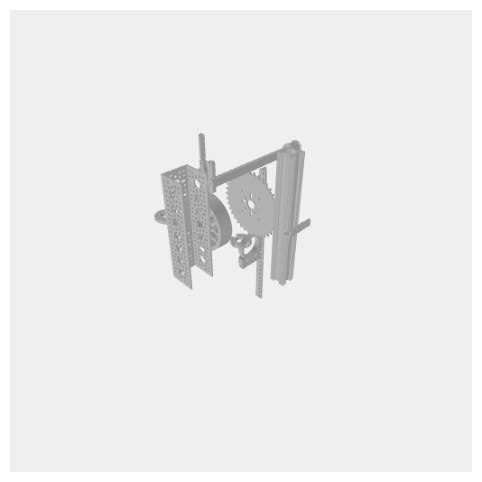

In [420]:
from itertools import product

scene = pyrender.Scene(
    bg_color=np.append(random_grayscale_color(0.9, 0.975), 1.0),
    ambient_light=[0.3, 0.3, 0.3, 1.0],
)

cam_isod = 350

cam_pose = look_at(np.array([cam_isod, cam_isod, cam_isod], dtype=np.dtypes.Float64DType))
scene.add(pyrender.PerspectiveCamera(yfov=np.pi / 3.0), pose=cam_pose)

for xm, ym, zm in np.array(list(product((-1, 1), repeat=3))):
    light_pose = look_at(np.array([cam_isod * xm, cam_isod * ym, cam_isod * zm], dtype=np.dtypes.Float64DType))
    light = pyrender.DirectionalLight(intensity=2.5)
    scene.add(light, pose=light_pose)

for t in transforms["transforms"]:
    i = steps.index(t["name"])
    m = meshes[i].copy()

    T = np.eye(4)
    T[:3, :3] = R.from_euler("xyz", t["Rotation"], degrees=True).as_matrix()
    T[:3, 3] = t["Position"]

    m.apply_transform(T)
    scene.add(pyrender.Mesh.from_trimesh(m))

color, _ = r.render(scene)

plt.figure(figsize=(8, 6))
plt.axis("off")
plt.imshow(color)
plt.show()

In [421]:
import json

def convert_and_sort(data):
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert(item) for item in obj]
        else:
            return obj

    converted_data = convert(data)
    if "transforms" in converted_data:
        converted_data["transforms"] = sorted(
            converted_data["transforms"], key=lambda x: x["name"]
        )

    return json.dumps(converted_data)


data = {
    "image": "blablabla.jpg",
}
data.update(transforms)
convert_and_sort(data)

'{"image": "blablabla.jpg", "origin_name": "CounterborePatternSpacer6.STEP", "transforms": [{"name": "CounterborePatternSpacer6.STEP", "Position": [1.186939505259943e-05, -0.2993149665919867, -5.47637776508042e-06], "Rotation": [0.0, -90.0, 0.0]}, {"name": "FlatBeam5H.STEP", "Position": [-79.66791699267927, 126.6904820973399, 1.9604344869694756e-08], "Rotation": [0.0, 0.0, -90.0]}, {"name": "HubMountAcetalSprocket38T.STEP", "Position": [19.974923316591727, 71.47323251059153, 4.996003610813204e-16], "Rotation": [0.0, 0.0, -90.0]}, {"name": "HubMountControlArm24.STEP", "Position": [-133.59932752356605, 3.618951655275787e-15, 38.4618535400242], "Rotation": [0.0, 0.0, 0.0]}, {"name": "IntakeWheel.STEP", "Position": [-79.6679071560465, -2.4360032710935384e-05, -0.0571205961876306], "Rotation": [0.0, 0.0, 0.0]}, {"name": "LBeam29H.STEP", "Position": [18.10875990920144, 1.8301568622776306e-07, -25.218119281608622], "Rotation": [0.0, 0.0, 0.0]}, {"name": "OpenGoRAIL192.STEP", "Position": [82.4

In [404]:
xyzms = xyzms = [v for v in product((-1, 0, 1), repeat=3) if v != (0, 0, 0) and sum(x != 0 for x in v) in (1, 3)]

len(xyzms)

14